# The Project #
1. This is a project with minimal scaffolding. Expect to use the the discussion forums to gain insights! It’s not cheating to ask others for opinions or perspectives!
2. Be inquisitive, try out new things.
3. Use the previous modules for insights into how to complete the functions! You'll have to combine Pillow, OpenCV, and Pytesseract
4. There are hints provided in Coursera, feel free to explore the hints if needed. Each hint provide progressively more details on how to solve the issue. This project is intended to be comprehensive and difficult if you do it without the hints.

### The Assignment ###
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images (like you saw in week 3). Your task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I would encourage you to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](./readonly/small_project.png)
If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):
![Mark Search](./readonly/large_project.png)

Note: That big file can take some time to process - for me it took nearly ten minutes! Use the small one for testing.

In [4]:
# importing all the necessary libraries
from zipfile import ZipFile
from PIL import Image
import pytesseract
import cv2 as cv
import numpy as np
from math import ceil
# loading the face detection classifier
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')

The zipfile library is a standard library intended to manipulate ZIP files.

Python Imaging Library is a module that adds support for opening, manipulating, and saving many different image file formats. The Image module provides a class with which an ordinary image is represented as PIL image and methods that can be used to perform operations on that image, such as loading or creating a new image.

cv2 or OpenCV is a library of programming functions mainly aimed at real-time computer vision.

Python-tesseract is an optical character recognition (OCR) tool for python. That is, it will recognize and “read” the text embedded in images.

numpy is a library for working with arrays.

Cascade classifier is a class for object detection.

# Haar cascade classifier

The Haarcascade frontal face recognition tasks is to recognize faces on an image. It processes an image and represents it as a pyramid with various levels, where each level goes from higher to lower resolution.
There are usually four levels, somtimes more. 

The scale factor is an indicator of how much should the image be reduced with each level. Higher values leads to higher misclassification, as it might miss some faces. On the other hand, lower values means more thorough, although quite slow. 

Lastly, mini-neighbors specifies how many neighboring rectangles have to be present to consider the current rectangle as valid. High values means great quality of face detection, but at the same time, it means fewer faces will be detected. 

In short, the Haar cascade classifier applies a sliding window approach. It slides its window across all pixels.

In [ ]:
# function that will load all the images in a zipfile, use the pytesseract algorithm to extract the text and return all found faces.
# all of these with the image title will be stored in a dictionary.
def img_dict(zip_file):
    with ZipFile(f'readonly/{zip_file}.zip') as img_zip:
        im_dict = {}
        for i in img_zip.infolist():
            face_lst = []
            name = i.filename
            pil_img_org = Image.open(img_zip.open(name))
            pil_img_gray_byte = np.array(pil_img_org.convert('L'))
            # for pytesseract grayscale images are more suitable, since they are easier to process.
            # the format of the image should be a numpy array.
            img_txt = pytesseract.image_to_string(pil_img_gray_byte)
            im_dict[name] = {'image':pil_img_org,'text_on_image':img_txt,'faces':face_lst}
            # the scale factor is 1.3, which means a reduction by 30% with each level and neighbors is 5.
            # thus, at least 5 rectangles for an object to be considered a face.
            face_ob = face_cascade.detectMultiScale(pil_img_gray_byte,1.3,5)
            if len(face_ob) != 0:
                for val in face_ob:
                    # face_ob will return the parameters, which can be passed to the crop method in order to capture that face
                    x,y,w,h=val[0],val[1],val[2],val[3]
                    # afterward, that face will be appended to the list that will be assigned to the key faces in the im_dict dictionary
                    face_lst.append(pil_img_org.crop((x,y,x+w,y+h)))
                im_dict[name]['faces'] = face_lst
            else:
                im_dict[name]['faces'] = 0
        return im_dict

In [6]:
# this function will create a contact sheet. The image size is 100 x 100. 5 images per row.
# that contact sheet will be assigned to the dictionary that was loaded from the previous function.
def cont_sheet(zip_file):
    img_details=img_dict(zip_file)
    cols = 5
    face_w,face_h = (100,100)
    for k in img_details.keys():
        if img_details[k]['faces'] != 0:
            x, y = (0, 0)
            rows = ceil(len(img_details[k]['faces']) / cols)
            contact_sheet = Image.new(img_details[k]['image'].mode, (face_w * cols, face_h * rows))
            for face in img_details[k]['faces']:
                face.thumbnail((face_w,face_h))
                contact_sheet.paste(face,(x,y))
                if x+face_w==contact_sheet.width:
                    x,y=0,y+face_h
                else:
                    x=x+face_w
            img_details[k]['contact_sheet'] = contact_sheet
        else:
            img_details[k]['contact_sheet'] = 0
    return img_details

In [7]:
# there are two zipfiles and both of them will be loaded to save computing power with the search and extract function.
small_zip, big_zip = cont_sheet('small_img'), cont_sheet('images')

In [8]:
# this function will return the contact sheet of images depending on the passed text.
# it will look for the word or text in the dictionary and once it is found;
# the contact sheet with the images belonging to that image is returned.
def search_and_extract(zip, text):
    if zip == 'small_img':
        img_dict = small_zip
    elif zip == 'images':
        img_dict = big_zip
    for k in img_dict.keys():
        if text in img_dict[k]['text_on_image']:
            if img_dict[k]['contact_sheet'] != 0:
                print(f'Results found in file {k}')
                display(img_dict[k]['contact_sheet'])
            else:
                # if the main image with the text contained no faces, then this message will be displayed.
                print(f'Results found in file {k}\nBut There were no faces in that file!')
                continue
        else:
            continue
    return

Results found in file a-0.png


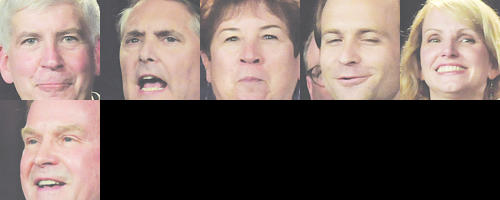

Results found in file a-3.png


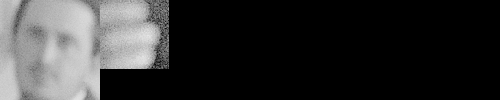

In [9]:
small_zip_res_chris = search_and_extract('small_img','Christopher')                    

Results found in file a-0.png


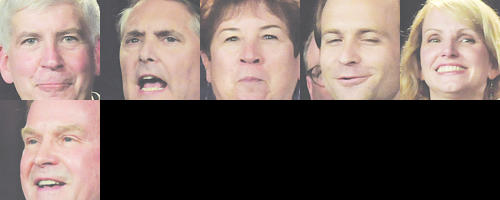

Results found in file a-1.png


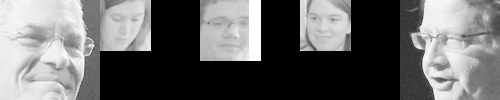

Results found in file a-2.png


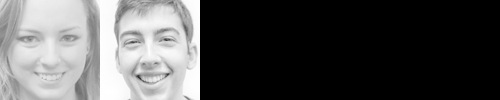

Results found in file a-3.png


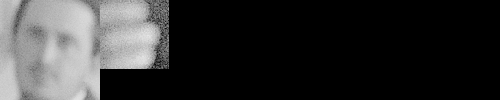

In [10]:
small_zip_res_mark = search_and_extract('small_img','Mark')

Results found in file a-0.png


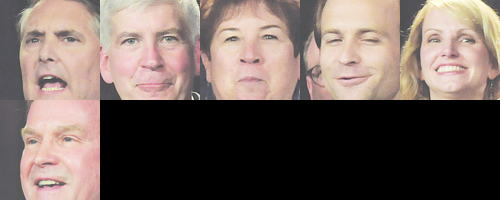

Results found in file a-3.png


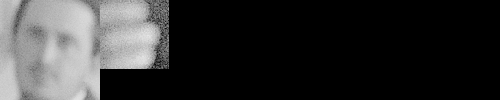

In [11]:
big_zip_res_chris = search_and_extract('images','Christopher')

Results found in file a-0.png


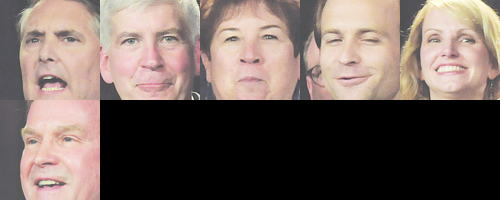

Results found in file a-1.png


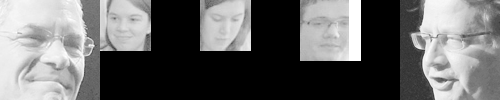

Results found in file a-10.png
But There were no faces in that file!
Results found in file a-13.png


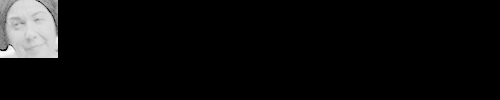

Results found in file a-2.png


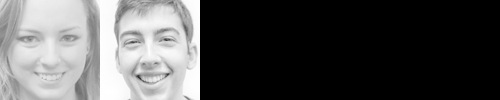

Results found in file a-3.png


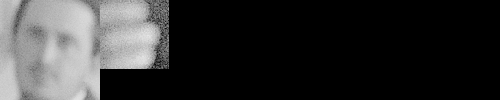

Results found in file a-8.png
But There were no faces in that file!


In [12]:
big_zip_res_mark = search_and_extract('images','Mark')